---
title: Partisipasi Tenaga Kerja Wanita di Amerika Serikat
author:
  - name: Taruma Sakti Megariansyah
    orcid: 0000-0002-1551-7673
    email: hi@taruma.info
    url: https://dev.taruma.info
abstract: > 
  The characteristic theme of the works of Stone is 
  the bridge between culture and society. ...
keywords:
  - Causal Inference
  - Python
  - Algoritma-DSS
license: "CC BY"
copyright: 
  holder: Taruma Sakti Megariansyah
  year: 2024
date: 2024-11-19
format:
    html:
        code-fold: true
        number-sections: true
        toc-title: Daftar Isi
        code-links:
        - text: Repository
          icon: github
          href: https://github.com/taruma/causal-mroz
        theme: journal
execute:
  enabled: false
toc: true
toc-location: left
citation: true
lightbox: auto
---

Pernah dengar ungkapan "korelasi bukan berarti hubungan sebab-akibat"? Meskipun dua hal terjadi bersamaan, belum tentu satu menyebabkan yang lain. Nah, di sinilah _causal inference_ berperan. _Causal inference_ membantu kita memahami bukan hanya apa yang terjadi, tetapi mengapa hal itu terjadi. Ini seperti menjadi detektif data, mencari petunjuk untuk mengungkap hubungan sebab-akibat yang sebenarnya, bukan hanya melihat kebetulan belaka.

Pada lembar kerja ini, data Mroz akan digunakan untuk mengilustrasikan penerapan teknik causal inference dalam memahami partisipasi tenaga kerja wanita di AS. Proses analisis akan meliputi perancangan diagram kausal untuk memvisualisasikan hubungan antar variabel, eksplorasi data untuk mengidentifikasi pola dan karakteristik penting, serta pemodelan statistik yang sesuai untuk mengisolasi dan mengukur efek kausal. Fokus utama adalah pada pengungkapan faktor-faktor yang secara kausal memengaruhi keputusan seorang wanita untuk bekerja atau tidak, analisis korelasi sederhana dengan menguji hubungan sebab-akibat antara variabel-variabel seperti jumlah anak, pendidikan, pendapatan suami, dan upah yang diharapkan.

::: {.callout-important}
## Lembar Kerja Pembelajaran

Lembar kerja ini merupakan bagian dari tugas **Data Science Series: Causal Inference for Business Decisions: Understanding Cause & Effect** yang diadakan oleh Algoritma pada tanggal 11-14 November 2024. Sehingga informasi yang disajikan dalam lembar kerja ini kemungkinan terdapat kekeliruan. Jika menemukan kekeliruan/kesalahan, dapat menyampaikannya melalui [isu github disini](https://github.com/taruma/causal-morz/issues/new). 
:::

## Pengaturan Awal

::: {.callout-note .column-margin}
Versi python yang digunakan adalah versi `3.11`. Pastikan membaca `README.md` untuk menjalankan notebook ini.
:::

Pada bagian ini akan dilakukan pengaturan untuk lembar kerja dan mengambil dataset `Mroz` dari paket `causaldata`.

In [5]:
# SETUP
import causaldata
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from causalgraphicalmodels import CausalGraphicalModel
from IPython.display import Markdown # noqa: F401

data_mroz = causaldata.Mroz.load_pandas().data

::: {.callout-caution collapse="true"}
## Output informasi dari data `Mroz`

**Output `causaldata.Mroz.TITLE`:**

`{python} Markdown(causaldata.Mroz.TITLE.replace('\n', '<br>'))` 

**Output `causaldata.Mroz.DESCRSHORT`:**

`{python} Markdown(causaldata.Mroz.DESCRSHORT.replace('\n', '<br>'))` 

**Output `causaldata.Mroz.DESCRLONG`:**

`{python} Markdown(causaldata.Mroz.DESCRLONG.replace('\n', '<br>'))` 

**Output `causaldata.Mroz.NOTE`:**

`{python} Markdown(causaldata.Mroz.NOTE.replace('\n', '<br>'))` 

**Output `causaldata.Mroz.SOURCE`:**

`{python} Markdown(causaldata.Mroz.SOURCE.replace('\n', '<br>'))` 
:::

## Data **Mroz**

Berdasarkan penjelasan singkat yang diperoleh dari `causaldata.Mroz`, Data **Mroz** merupakan sebuah dataset _cross-sectional_ dari tahun 1987 yang berisi informasi tentang partisipasi tenaga kerja wanita di Amerika Serikat. Data ini dikumpulkan oleh Thomas A. Mroz sebagai bagian dari Panel Study of Income Dynamics (PSID).

In [6]:
# Clean up column names and show a sample of the data
df_mroz = data_mroz.set_index(data_mroz.columns[0]).rename_axis('no')
df_mroz.sample(5)

,lfp,k5,k618,age,wc,hc,lwg,inc
no,,,,,,,,
273,True,0,3,48,False,False,0.181253,13.392000
53,True,0,8,37,False,False,0.162519,16.257999
314,True,0,0,53,False,False,1.518311,9.800001
3,True,1,3,35,False,False,1.514128,12.039999
374,True,1,1,34,False,False,1.499556,6.599998


In [7]:
#| column: margin

# Information about the dataset
df_mroz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 1 to 753
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lfp     753 non-null    bool   
 1   k5      753 non-null    int64  
 2   k618    753 non-null    int64  
 3   age     753 non-null    int64  
 4   wc      753 non-null    bool   
 5   hc      753 non-null    bool   
 6   lwg     753 non-null    float64
 7   inc     753 non-null    float64
dtypes: bool(3), float64(2), int64(3)
memory usage: 37.5 KB


Dari sampel data dan informasi data **Mroz**, berikut informasi yang dapat diambil:

- Data **Mroz** terdiri dari $753$ observasi/baris dan $8$ variabel. Dan tidak ada nilai yang hilang karena seluruh variabel memberikan informasi `753 non-null` (sejumlah dengan observasi). 
- **lfp (Labor-force participation):** Variabel biner yang menunjukkan apakah seorang wanita berpartisipasi dalam tenaga kerja (1) atau tidak (0). Inilah variabel outcome (Y) yang ingin kita pahami.
- **k5 (Number of children 5 years old or younger):** Jumlah anak berusia 5 tahun atau lebih muda.
- **k618 (Number of children 6 to 17 years old):** Jumlah anak berusia 6 hingga 17 tahun.
- **age:** Usia wanita dalam tahun.
- **wc (Wife attended college):** Variabel biner yang menunjukkan apakah istri berkuliah (1) atau tidak (0).
- **hc (Husband attended college):** Variabel biner yang menunjukkan apakah suami berkuliah (1) atau tidak (0).
- **lwg (Log expected wage rate):** Logaritma dari tingkat upah yang diharapkan. Untuk wanita yang bekerja, ini adalah tingkat upah aktual; untuk wanita yang tidak bekerja, ini adalah nilai yang diimputasi berdasarkan regresi lwg pada variabel lain.
- **inc (Family income exclusive of wife’s income):** Pendapatan keluarga tidak termasuk pendapatan istri.

Karena data Mroz merupakan data observational, yaitu data yang dikumpulkan tanpa intervensi atau manipulasi langsung oleh peneliti, maka _Randomized Controlled Trial (RCT)_ tidak sesuai untuk kasus ini. Sebagai alternatif, digunakan _Quasi-Experimental Approach_, dimana menganalisis data yang sudah ada dan berupaya mengisolasi hubungan sebab-akibat dengan memanfaatkan variasi yang terjadi secara alami dan teknik statistik untuk memperhitungkan faktor-faktor lain yang berpengaruh. Sehingga penggunaan _Quasi-Experimental Approach_ merupakan pendekatan yang sesuai dengan kasus ini.

## Tujuan dan Hipotesis Kausal

Bagian ini menjelaskan tujuan analisis dan hipotesis kausal yang akan diuji. Mengingat data Mroz merupakan data observasional, fokusnya adalah mengungkap hubungan sebab-akibat antara variabel-variabel yang ada, khususnya pengaruh **pendidikan wanita** terhadap **partisipasinya dalam tenaga kerja** di AS.

### Tujuan

Tujuan utama dari analisis ini adalah untuk mengestimasi efek kausal dari pendidikan tinggi wanita (`wc`) terhadap partisipasinya dalam tenaga kerja (`lfp`), dengan mempertimbangkan variabel-variabel lain yang mungkin menjadi *confounder*. Secara spesifik, analisis ini ingin menjawab pertanyaan: **Apakah seorang wanita yang berkuliah (perguruan tinggi) memiliki probabilitas lebih tinggi untuk berpartisipasi dalam tenaga kerja dibandingkan dengan wanita yang tidak berkuliah, setelah memperhitungkan faktor-faktor lain seperti usia, jumlah anak, pendapatan keluarga, dan pendidikan suami?**

### Hipotesis Kausal

Hipotesis nol ($H_0$) dan hipotesis alternatif ($H_1$) dirumuskan sebagai berikut:

- $H_0$: Tidak ada efek kausal dari pendidikan tinggi istri (`wc`) terhadap partisipasinya dalam tenaga kerja (`lfp`), setelah mengontrol variabel *confounding*.
- $H_1$: Terdapat efek kausal dari pendidikan tinggi istri (`wc`) terhadap partisipasinya dalam tenaga kerja (`lfp`), setelah mengontrol variabel *confounding*. Lebih spesifik, dihipotesiskan bahwa istri yang berkuliah memiliki probabilitas lebih tinggi untuk berpartisipasi dalam tenaga kerja.

## Diagram Kausal

Bagian ini bertujuan untuk membangun diagram kausal (Directed Acyclic Graph - DAG) yang merepresentasikan hubungan sebab-akibat antar variabel dalam data Mroz. DAG ini akan menjadi panduan dalam  menganalisis pengaruh pendidikan wanita (*wc*) terhadap partisipasinya dalam tenaga kerja (*lfp*). Perlu dicatat bahwa interpretasi diagram kausal ini ditentukan secara subjektif, sehingga perbedaan perspektif atau pemodelan mungkin terjadi. 

### Identifikasi Variabel

Variabel-variabel yang dipertimbangkan dalam analisis ini, beserta perannya masing-masing, adalah sebagai berikut:

- **lfp (Labor-force participation):** Variabel dependen/outcome (Y) yang menunjukkan partisipasi seorang wanita dalam tenaga kerja (1 = berpartisipasi, 0 = tidak berpartisipasi).
- **wc (Wife attended college):** Variabel treatment/perlakuan (X) yang menunjukkan apakah seorang wanita berkuliah (1) atau tidak (0).
- **age (Age):** Usia wanita, berperan sebagai variabel *confounding* yang berpotensi memengaruhi `wc` dan `lfp`.
- **k5 (Number of children 5 years old or younger):** Jumlah anak berusia 5 tahun atau lebih muda. Diperkirakan memengaruhi `lfp`.
- **k618 (Number of children 6 to 17 years old):** Jumlah anak berusia 6 hingga 17 tahun.  Diperkirakan memengaruhi `lfp`.
- **hc (Husband attended college):**  Pendidikan suami, berpotensi memengaruhi `lfp` dan `inc`.
- **lwg (Log expected wage rate):** Logaritma dari tingkat upah yang diharapkan. Diperkirakan dipengaruhi `wc` dan memengaruhi `lfp`.
- **inc (Family income exclusive of wife’s income):** Pendapatan keluarga (tidak termasuk pendapatan istri). Diperkirakan dipengaruhi `hc` dan memengaruhi `lfp`.

### Pertimbangan dalam Menentukan Hubungan Kausal

Hubungan kausal antar variabel ditentukan berdasarkan pendekatan dan pemahaman saya. Berikut beberapa pertimbangan yang mendasari pembentukan DAG:

* **Pengaruh Usia:** Usia (`age`) diasumsikan memengaruhi pendidikan wanita (`wc`), partisipasi tenaga kerja (`lfp`), dan jumlah anak (`k5` dan `k618`).
* **Pengaruh Pendidikan:** Pendidikan wanita (`wc`) diasumsikan memengaruhi partisipasi tenaga kerja (`lfp`) dan tingkat upah yang diharapkan (`lwg`).
* **Pengaruh Pendidikan Suami:** Pendidikan suami (`hc`) diasumsikan memengaruhi pendapatan keluarga (`inc`) dan, secara tidak langsung, partisipasi istri dalam tenaga kerja (`lfp`).
* **Pengaruh Anak:** Jumlah anak (`k5` dan `k618`) diasumsikan memengaruhi partisipasi wanita dalam tenaga kerja (`lfp`).
* **Pengaruh Pendapatan & Upah:** Pendapatan keluarga (`inc`) dan tingkat upah yang diharapkan (`lwg`) diasumsikan memengaruhi partisipasi wanita dalam tenaga kerja (`lfp`).

### Diagram Kausal (DAG)

Untuk menyederhanakan diagram atau model, dipertimbangan untuk mengabaikan variabel `lwg` dalam penyelesaian Causal Inference dalam lembar kerja ini. Berikut representasi visual dari hubungan kausal yang telah dibahas sebelumnya di atas:

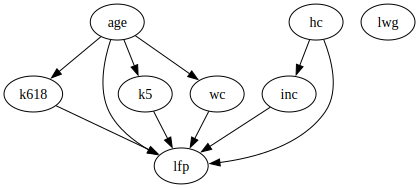

In [8]:
#| label: fig-dag-mroz
#| fig-cap: Diagram Kausal Partisipasi Seorang Wanita dalam Tenaga Kerja
#| fig-scap: DAG Mroz
#| fig-align: center

# Definisikan variabel
variables = df_mroz.columns

# Definisikan edges (hubungan kausal)
edges = [('age', 'wc'), ('age', 'lfp'), ('age', 'k5'), ('age', 'k618'),
         ('wc', 'lfp'), ('hc', 'lfp'), ('hc', 'inc'),
         ('k5', 'lfp'), ('k618', 'lfp'), ('inc', 'lfp')]

# Buat DAG
dag = CausalGraphicalModel(nodes=variables, edges=edges)

# Plot DAG
dag.draw()

Diagram kausal (@fig-dag-mroz) di atas menggambarkan asumsi subjektif tentang hubungan kausal antar variabel dalam data Mroz. Diagram ini menunjukkan bagaimana faktor-faktor seperti usia, jumlah anak, pendidikan suami, dan pendapatan keluarga, bersama dengan pendidikan wanita, dapat memengaruhi partisipasi wanita dalam tenaga kerja. Arah panah mengindikasikan arah hubungan kausal yang diasumsikan. Penting untuk dicatat bahwa DAG ini merupakan representasi hipotesis yang perlu divalidasi lebih lanjut.

## Exploratory Data Analysis

Pada bagian Exploratory Data Analysis (EDA) ini, akan dikaji karakteristik data Mroz untuk memahami pola, distribusi variabel, dan hubungan antar variabel, sebelum melangkah ke analisis kausal. Pemahaman data yang komprehensif melalui EDA krusial untuk membangun model kausal yang akurat dan valid, memvalidasi asumsi, serta memastikan interpretasi yang tepat terhadap efek pendidikan wanita (`wc`) pada partisipasi angkatan kerja (`lfp`).

In [13]:
df_mroz.describe().map('{:.2f}'.format)

,k5,k618,age,lwg,inc
count,753.00,753.00,753.00,753.00,753.00
mean,0.24,1.35,42.54,1.10,20.13
std,0.52,1.32,8.07,0.59,11.63
min,0.00,0.00,30.00,-2.05,-0.03
25%,0.00,0.00,36.00,0.82,13.02
50%,0.00,1.00,43.00,1.07,17.70
75%,0.00,2.00,49.00,1.40,24.47
max,3.00,8.00,60.00,3.22,96.00
